In [181]:
import os
import json
import csv
import tld
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd

client = Client(n_workers=2, threads_per_worker=2, memory_limit='6GB')

In [3]:
DATASET_PATH = "datasets"

filename = "quotes-2020.parquet"

dataset = dd.read_parquet(os.path.join(DATASET_PATH, filename))

In [4]:
# Convert date column to datetime objects
dataset["date"] = dd.to_datetime(dataset["date"])

In [133]:
# Print the dataset
dataset.head(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,urls,phase,speaker_prob,url_countries,day_of_week
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,None,2020-01-28 08:04:05,1,[http://israelnationalnews.com/News/News.aspx/...,E,0.7272,[IS],Tuesday
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,Q367796,2020-01-16 12:00:13,1,[http://thehill.com/opinion/international/4782...,E,0.8867,[US],Thursday
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,None,2020-02-10 23:45:54,1,[https://indianexpress.com/article/business/ec...,E,0.8926,[IN],Monday
3,2020-02-15-000053,"... [ I ] f it gets to the floor,",None,None,2020-02-15 14:12:51,2,[https://patriotpost.us/opinion/68622-trump-bu...,E,0.5810,[US],Saturday
4,2020-01-24-000168,[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds,Q20684375,2020-01-24 20:37:09,4,[https://people.com/parents/meghan-king-edmond...,E,0.5446,[US],Friday


In [22]:
ds_by_day = dataset.set_index("date").resample("1D")
number_of_quotes_per_day = ds_by_day.size().compute()

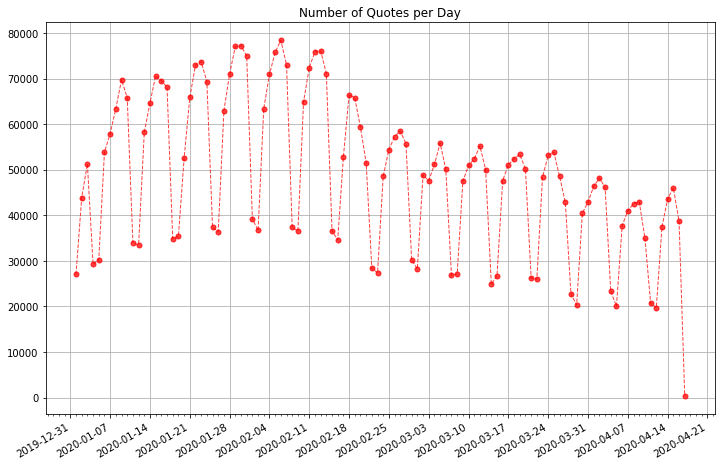

In [78]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.set_title("Number of Quotes per Day")

# Major ticks every week.
fmt_week = mdates.WeekdayLocator(interval=1)
ax.xaxis.set_major_locator(fmt_week)

# Minor ticks every day.
fmt_day = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_day)

# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Round to nearest months.
datemin = np.datetime64(number_of_quotes_per_day.index[0], 'W')
datemax = np.datetime64(number_of_quotes_per_day.index[-1], 'W') + np.timedelta64(1, 'W')
ax.set_xlim(datemin, datemax)
ax.grid(True)
ax.plot(number_of_quotes_per_day, c="r", linewidth=1, alpha=0.75, marker="o", linestyle="--", markersize=5)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

I wonder why there is a sharp decrease in the middle of each week. Is it because of the weekdays/weekends?

In [91]:
dataset["day_of_week"] = dataset["date"].dt.day_name()
ds_by_weekdays = dataset.groupby(dataset["day_of_week"])
number_of_quotes_per_weekday = ds_by_weekdays.size().compute()

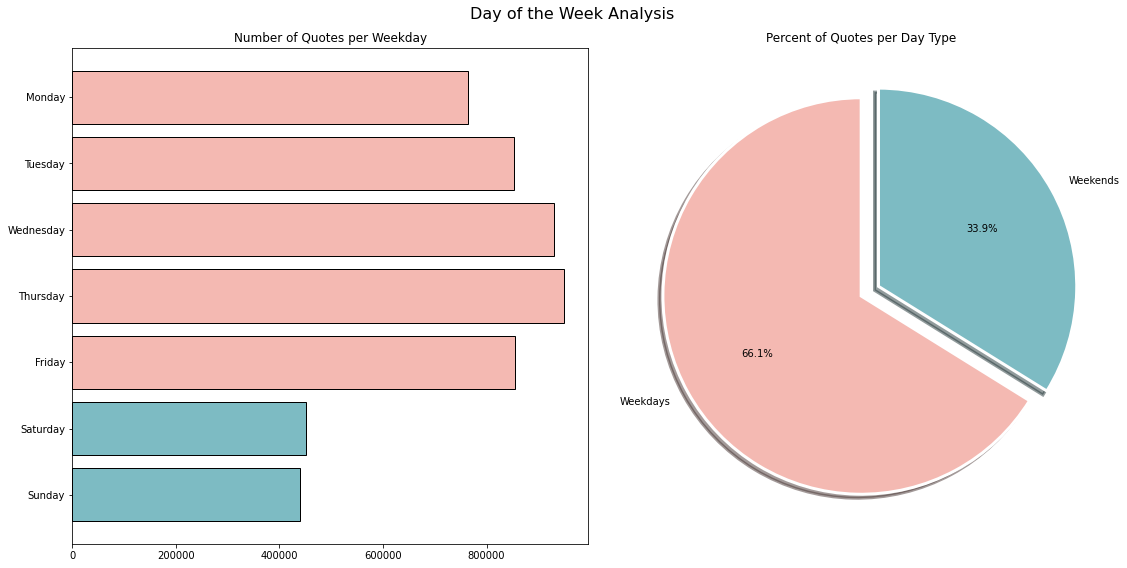

In [136]:
# Sort the index by the day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_type = (days_of_week[:5], days_of_week[5:])

mapping = {day: i for i, day in enumerate(reversed(days_of_week))}
key = number_of_quotes_per_weekday.index.map(mapping)
number_of_quotes_per_weekday = number_of_quotes_per_weekday.iloc[key.argsort()]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("Number of Quotes per Weekday", fontsize=12)
ax[1].set_title("Percent of Quotes per Day Type", fontsize=12)
fig.suptitle("Day of the Week Analysis", fontsize=16)

colors = ["#7DBBC3", "#7DBBC3", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2", "#F4B9B2"]
ax[0].barh(number_of_quotes_per_weekday.index, number_of_quotes_per_weekday, edgecolor="black", color=colors)

ax[1].pie([number_of_quotes_per_weekday.loc[x].mean() for x in day_type], labels=["Weekdays", "Weekends"], autopct='%.1f%%', shadow=True, startangle=90, colors=["#F4B9B2", "#7DBBC3"], wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, explode=(0, 0.1))
plt.tight_layout()

Aha, we were right! Apparently many people decide to stay silent during the weekend.

Let's explore the trends

In [147]:
quote_trends_daily = pd.DataFrame({"n_quotes": number_of_quotes_per_day}, index=number_of_quotes_per_day.index)
quote_trends_7 = quote_trends_daily["n_quotes"].rolling(window=7, center=True, min_periods=5).mean()
quote_trends_30 = quote_trends_daily["n_quotes"].rolling(window=30, center=True, min_periods=20).mean()

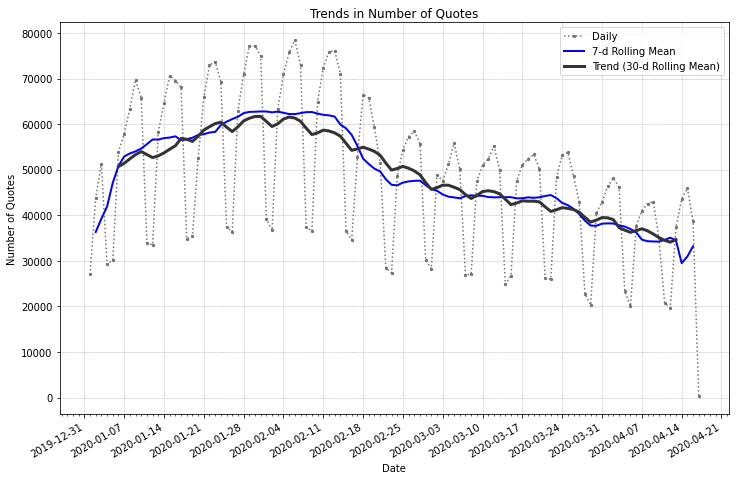

In [166]:
# Plot daily, 7-day rolling mean, and 30-day rolling mean
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(number_of_quotes_per_day, marker=".", markersize=4.5, color="0.45", linestyle="dotted", label="Daily")
ax.plot(quote_trends_7, linewidth=2, label='7-d Rolling Mean', color="b")
ax.plot(quote_trends_30, color="0.2", linewidth=3, label="Trend (30-d Rolling Mean)")

# Major ticks every week.
fmt_week = mdates.WeekdayLocator(interval=1)
ax.xaxis.set_major_locator(fmt_week)

# Minor ticks every day.
fmt_day = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_day)

# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.legend()
ax.grid(True, linewidth=0.5, linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Quotes")
ax.set_title("Trends in Number of Quotes")

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

TODO: Explore the number of occurrences

<AxesSubplot:xlabel='numOccurrences'>

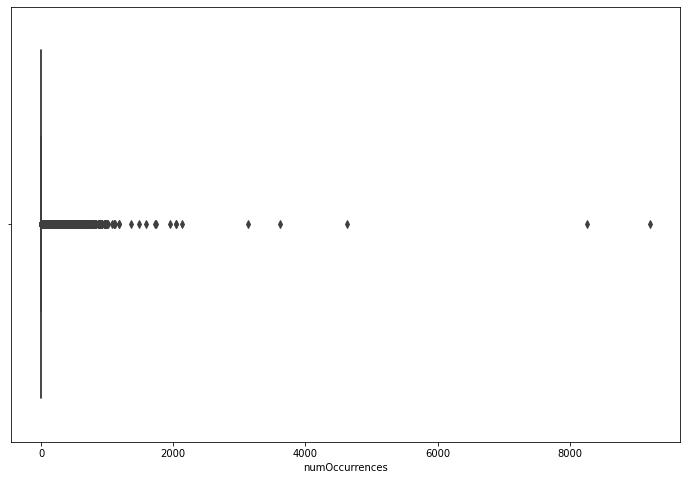

In [174]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=dataset["numOccurrences"].astype(np.int64))
plt.show()


Woah! So many outliers... Or are they really?

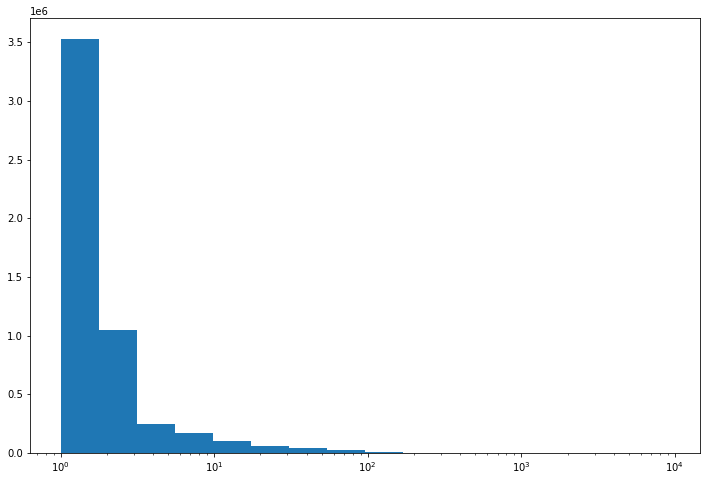

In [177]:
fig, ax = plt.subplots(1, figsize=(12, 8))
hist, bins = np.histogram(dataset["numOccurrences"].astype(np.int64), bins=16)
log_bins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.hist(dataset["numOccurrences"].astype(np.int64), bins=log_bins)
plt.xscale('log')
plt.show()

TODO: Explore speaker probabilities

<AxesSubplot:xlabel='speaker_prob'>

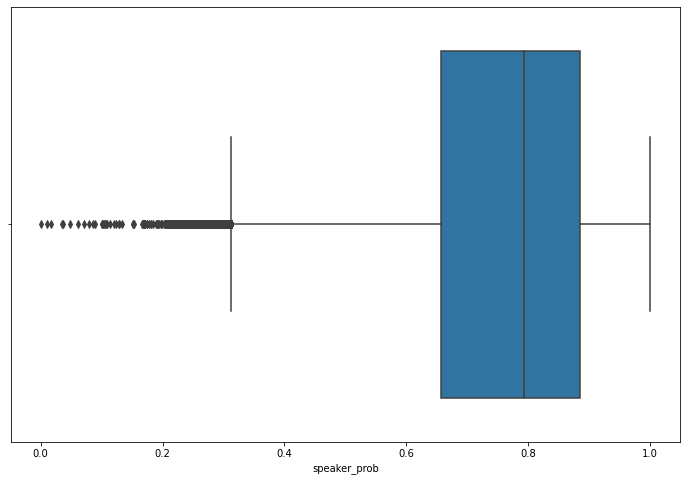

In [179]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=dataset["speaker_prob"].astype(np.float64))
plt.show()

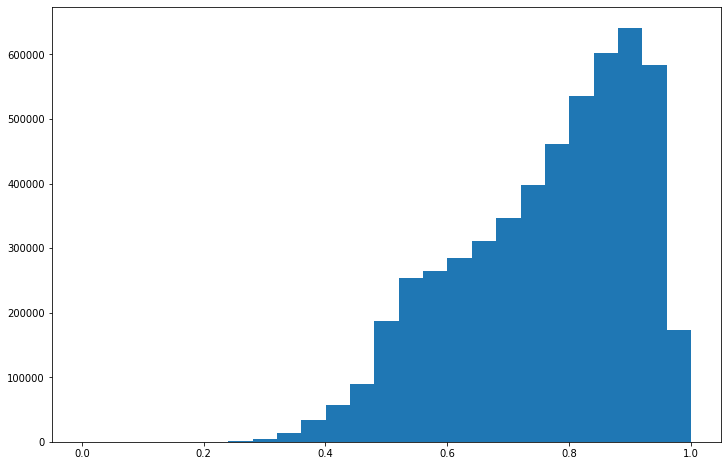

In [184]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.hist(dataset["speaker_prob"].astype(np.float64), bins=25)
plt.show()

TODO: Explore the length of the quote

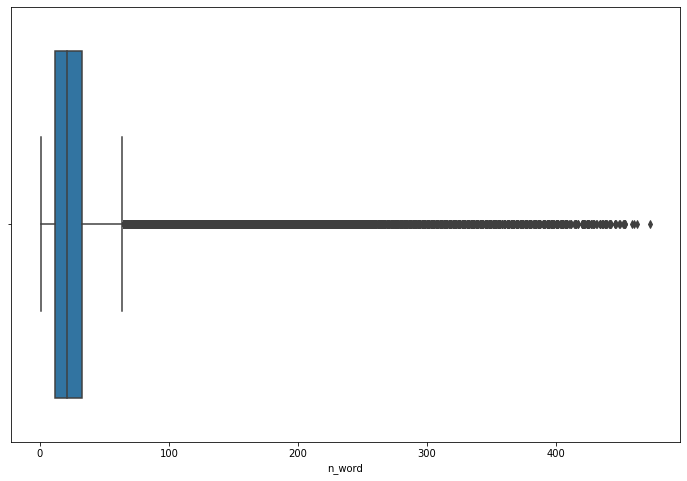

In [189]:
# Get the number of words per quote
dataset["n_word"] = dataset.apply(lambda x: len(re.compile(r'\w+').findall(x["quotation"])), axis=1, meta="np.int64")

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.boxplot(x=dataset["n_word"])
plt.show()

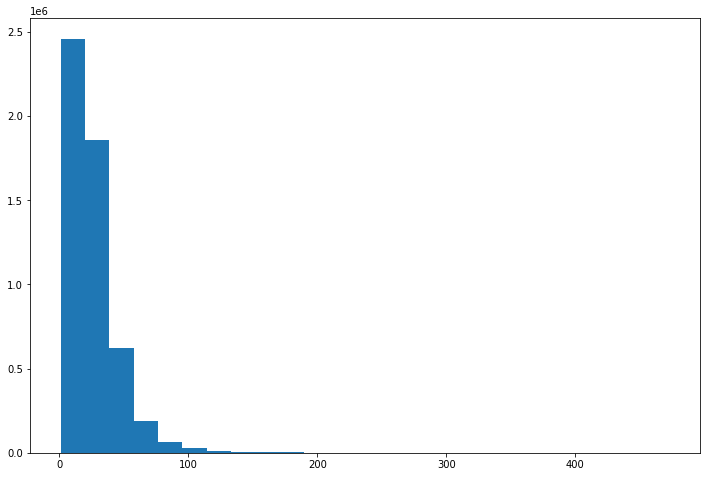

In [188]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.hist(dataset["n_word"], bins=25)
plt.show()
